In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics

from IPython.display import display
from io import StringIO

warnings.simplefilter('ignore')

##### Load datasets

Nos passos abaixo foram aplicados os seguintes tratamentos:

    Datasets carregados, um de logs das intencoes e textos e outro com titulos de filmes com a intencão 003_PROGRAMA
    Excluida as colunas que não serão utilizadas
    Merge dos datasets
    Dados ausentes (NaN) eliminados
    Retirado numeros e caracteres especiais
    Substituido 'TOKEN SHOW MORE' por Filmes de ação

In [13]:
dataset = pd.read_csv('df_logs.csv')
movies_df = pd.read_csv('movies_df.csv')

In [14]:
cols = ['texto','intencao']
dataset = dataset[cols]

In [18]:
dataset = dataset.append(movies_df)

In [30]:
dataset.dropna(inplace=True)

In [31]:
dataset.isna().sum()

texto          0
intencao       0
intencao_id    0
dtype: int64

In [55]:
dataset['texto'] = dataset['texto'].str.replace('\d+','')## Exclui numeros do texto (influência no controle remoto)
dataset['texto'] = dataset['texto'].str.replace('TOKEN_SHOW_MORE','Filmes de ação')

##### Gráfico de barras com a contagem das intencões.

In [ ]:
fig = plt.figure(figsize=(25,15))
dataset.groupby('intencao').texto.count().plot.bar(ylim=0)
plt.show()

##### Cria a coluna intencao_id com versão numérica das intencões.

In [32]:
#dataset['intencao'] = dataset['intencao'].astype('category')
dataset['intencao_id'] = dataset['intencao'].factorize()[0]

intencao_id_df = dataset[['intencao', 'intencao_id']].drop_duplicates().sort_values('intencao_id')
intencao_to_id = dict(intencao_id_df.values)
id_to_intencao = dict(intencao_id_df[['intencao_id', 'intencao']].values)

##### Vetorizando o dataset, separando features e labels.

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(dataset.texto).toarray()
labels = dataset.intencao
features.shape

##### Palavras associadas a cada intencão usando chi2.

In [ ]:
N = 2
for dataset['intencao'], dataset['intencao_id'] in sorted(intencao_to_id.items()):
  features_chi2 = chi2(features, labels == intencao_to_id.items)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(intencao_to_id.items))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

### Train and Test Split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(dataset['texto'], dataset['intencao'], random_state = 10)

##### Naive Bayes Multinomial de teste

In [35]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [36]:
print(clf.predict(count_vect.transform(["ver fatura "])))

['004_sugestao']


### Multiple Models

    Random Forest
    Support Vector Machines SVM
    Naive bayes Multinomial
    Regressão Logistica
    
Abaixo boxplot da acurácia de cada modelo

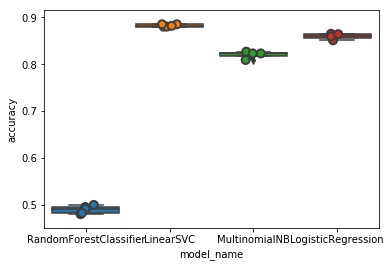

In [37]:
models = [
    RandomForestClassifier(n_estimators=300, max_depth=9, random_state=1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=1),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [40]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.882665
LogisticRegression        0.859167
MultinomialNB             0.820165
RandomForestClassifier    0.490285
Name: accuracy, dtype: float64

##### MAtriz de confusão (Muito grande devido a quantidade de classes (visualização inviável)).

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, dataset.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=intencao_id_df.intencao.values, yticklabels=intencao_id_df.intencao.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
for predicted in intencao_id_df.intencao_id:
  for actual in intencao_id_df.intencao_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_intencao[actual], id_to_intencao[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['intencao', 'texto']])
      print('')

### Test

In [ ]:
texts = ['quero trocar de pacote','troca de controle remoto','agendamento de visita técnica',
         'quero assistir megatubarao','me conte uma piada legal','comprar BBB 19','comprar canal adulto',
         'trocar de endereço','mudar endereço de instalação', 'the big bang theory','predador',
         'O valor da fatura está errado','pagar fatura com cartao de credito do banco xpto',
         'ação','futebol','terror','canais de desenho','quero mudar de plano','me fale sobre voce',
         'quem é seu pai?','peppa pig','pentera negra','alcoolismo na adolescencia, no globo reporter',
         'Jogos do Brasil', 'fluminence x palmeiras','olá como voce vai?','valeu ai']

text_features = tfidf.transform(texts)
predictions = model.predict(text_features)

for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format([predicted]))
  print("")

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=dataset['intencao'].unique()))

#### Validação dados de janeiro

In [52]:
validacao = pd.read_csv('logs_validacao.csv')
validacao['texto'] = validacao['texto'].str.replace('\d+','')
validacao['texto'] = validacao['texto'].str.replace('...,-,..-, ,!,@,#,$,%,ˆ,&,*,(,?,),{,[,],},:,;,_,\'+,=,|,\,/,>,<','')
valid = []
validacao.texto.unique()
valid = validacao.texto.unique() 
valid

array([' Que dia que vai passar ?', ' Vikings ', ' megatubarao', ...,
       'Ola! Ontem fui em uma lotérica e paguei um pacote com mais canais, para ter um upgrade durante esse mês ',
       'Promessa', 'Promessa de pagamento '], dtype=object)

In [53]:
text_features = tfidf.transform(valid)
predictions = model.predict(text_features)

for text, predicted in zip(valid, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format([predicted]))
  print("")

" Que dia que vai passar ?"
  - Predicted as: '['004_sugestao']'

" Vikings "
  - Predicted as: '['004_sugestao']'

" megatubarao"
  - Predicted as: '['003_PROGRAMAS']'

" opa do nordeste "
  - Predicted as: '['003_PROGRAMAS']'

"'+"
  - Predicted as: '['003_PROGRAMAS']'

". com. BR.  www. compra.  canal.  de.    futebol"
  - Predicted as: '['004_sugestao']'

".quero desbroquea meus canais"
  - Predicted as: '['005_ver_canais']'

""
  - Predicted as: '['003_PROGRAMAS']'

" . é o CPF"
  - Predicted as: '['005_erro_login']'

"..-"
  - Predicted as: '['003_PROGRAMAS']'

"_"
  - Predicted as: '['003_PROGRAMAS']'

"..."
  - Predicted as: '['003_PROGRAMAS']'

" ponto sky"
  - Predicted as: '['005_ponto_adicional']'

" progama"
  - Predicted as: '['003_PROGRAMAS']'

" id"
  - Predicted as: '['004_sugestao']'

" minutos com Juliana Paes"
  - Predicted as: '['003_PROGRAMAS']'

" via"
  - Predicted as: '['003_PROGRAMAS']'

" via "
  - Predicted as: '['003_PROGRAMAS']'

"Horas"
  - Predicted as: 

"Qual canal está passando a copinha"
  - Predicted as: '['004_sugestao']'

"Qual canal está passando copa São Paulo de futebol Júnior "
  - Predicted as: '['004_sugestao']'

"Qual canal teclo para saber código de acesso do aparelho?"
  - Predicted as: '['004_sugestao']'

"Qual canal vai passa o jogo do bahia"
  - Predicted as: '['004_sugestao']'

"Qual o canal da globo ?"
  - Predicted as: '['004_sugestao']'

"Qual o card principal da Tc combate sábado?"
  - Predicted as: '['004_sugestao']'

"Qual o plano que tem o BBB"
  - Predicted as: '['005_BBB']'

"Qual o valor do canal do big brother Brasil?"
  - Predicted as: '['005_BBB']'

"Qual o valor do pacote do bbb"
  - Predicted as: '['005_BBB']'

"Qual o valor?"
  - Predicted as: '['005_ver_fatura']'

"Qual valor?"
  - Predicted as: '['005_ver_fatura']'

"Qual é o melhor filme de comédia que você tem"
  - Predicted as: '['004_sugestao']'

"Qual é o melhor filme que você tem"
  - Predicted as: '['004_sugestao']'

"Quando  o valor da minha

  - Predicted as: '['003_PROGRAMAS']'

"cartoon"
  - Predicted as: '['004_sugestao']'

"cartoon nectw"
  - Predicted as: '['004_sugestao']'

"cartoon nethwrque"
  - Predicted as: '['004_sugestao']'

"cartoon network"
  - Predicted as: '['004_sugestao']'

"cartão de crédito"
  - Predicted as: '['005_bandeiras_cartao_recarga']'

"casa de papel"
  - Predicted as: '['005_mudar_endereco_instalacao']'

"casa do medo"
  - Predicted as: '['003_PROGRAMAS']'

"casa dos sonhos "
  - Predicted as: '['003_PROGRAMAS']'

"casa lotérica"
  - Predicted as: '['003_PROGRAMAS']'

"catfish"
  - Predicted as: '['003_PROGRAMAS']'

"cavalo de guerra"
  - Predicted as: '['003_PROGRAMAS']'

"cd leganes"
  - Predicted as: '['003_PROGRAMAS']'

"centrado"
  - Predicted as: '['003_PROGRAMAS']'

"central de atendimento ao cliente"
  - Predicted as: '['005_atendimento']'

"certo"
  - Predicted as: '['000_agradecimento']'

"chamada de vídeo chamada de vídeo"
  - Predicted as: '['003_PROGRAMAS']'

"chamada vídeo chamad

  - Predicted as: '['003_PROGRAMAS']'

"filme de guerra"
  - Predicted as: '['004_sugestao']'

"filme de sexo "
  - Predicted as: '['005_conteúdo_adulto']'

"filme de suspense"
  - Predicted as: '['004_sugestao']'

"filme de terro"
  - Predicted as: '['004_sugestao']'

"filme de terror"
  - Predicted as: '['004_sugestao']'

"filme de tubarão"
  - Predicted as: '['004_sugestao']'

"filme de tubarão hoje"
  - Predicted as: '['004_sugestao']'

"filme de. suspense com drama dublado"
  - Predicted as: '['004_sugestao']'

"filme do Dragon Ball Z"
  - Predicted as: '['004_sugestao']'

"filme do Lucas"
  - Predicted as: '['004_sugestao']'

"filme do Lucas Neto de Natal"
  - Predicted as: '['004_sugestao']'

"filme do Luccas Neto"
  - Predicted as: '['004_sugestao']'

"filme do Luccas Neto para assistir"
  - Predicted as: '['004_sugestao']'

"filme infantil"
  - Predicted as: '['004_sugestao']'

"filme meg tubarao"
  - Predicted as: '['004_sugestao']'

"filme mega tubarão"
  - Predicted as: '['


"nao consigo acessar meu aplicativo sky"
  - Predicted as: '['005_atendimento']'

"nao consigo achar a senha d acesso pra alugar um filme"
  - Predicted as: '['004_sugestao']'

"nao consigo atendimento"
  - Predicted as: '['005_atendimento']'

"nao consigo entrar em contado para adquirir um ponto sky"
  - Predicted as: '['005_ponto_adicional']'

"nao consigo entrar na mimha conta"
  - Predicted as: '['005_atendimento']'

"nao consigo entrar no app minha sky"
  - Predicted as: '['004_sugestao']'

"nao consigo entrar no login"
  - Predicted as: '['005_erro_login']'

"nao consigo logar"
  - Predicted as: '['005_atendimento']'

"nao consiqo compra pacote"
  - Predicted as: '['005_comprar_ppv']'

"nao da pra clicar em atendimento"
  - Predicted as: '['005_atendimento']'

"nao esta recebendo bbc world. Tem uma problema?"
  - Predicted as: '['005_atendimento']'

"nao estou  consiguindo compra pacote"
  - Predicted as: '['005_atendimento']'

"nao estou conseguindo"
  - Predicted as: '['005_me

  - Predicted as: '['005_incluir_canais']'

"queria trocar de aparelho"
  - Predicted as: '['005_incluir_canais']'

"queria ver pra almentar os canais liberar"
  - Predicted as: '['004_sugestao']'

"queria ver tenho pré pago e meu controle nao vai"
  - Predicted as: '['005_atendimento']'

"queria ver toy story mas esta dando conteudo nao disponível"
  - Predicted as: '['004_sugestao']'

"quero EXCLUIR canais"
  - Predicted as: '['005_retirar_canais_adicionais']'

"quero a TV novamente"
  - Predicted as: '['005_ver_visita_tecnica']'

"quero a medição de senha eu preciso ser tomada no meu e-mail"
  - Predicted as: '['004_sugestao']'

"quero acessar meu App"
  - Predicted as: '['005_avaliar_app']'

"quero acessar o aplicativo"
  - Predicted as: '['005_ver_fatura']'

"quero adicionar mais um ponto da skay"
  - Predicted as: '['005_ponto_adicional']'

"quero adicionar o Premier"
  - Predicted as: '['004_sugestao']'

"quero adquirir outro ponto sky"
  - Predicted as: '['004_sugestao']'

"que

"venon"
  - Predicted as: '['003_PROGRAMAS']'

"ver a globol"
  - Predicted as: '['004_sugestao']'

"ver canais"
  - Predicted as: '['005_incluir_canais']'

"ver filme na sky"
  - Predicted as: '['004_sugestao']'

"ver o filme de lançamento"
  - Predicted as: '['004_sugestao']'

"ver o valor que tem que pagar da minha Sky"
  - Predicted as: '['004_sugestao']'

"ver o vencimento do minha fatura "
  - Predicted as: '['005_ver_fatura']'

"ver se reserve para mim uns filmes de desenhos tá bom"
  - Predicted as: '['004_sugestao']'

"verifica meus dadas ai pra mim quero paga"
  - Predicted as: '['005_ver_fatura']'

"vernon"
  - Predicted as: '['003_PROGRAMAS']'

"vh"
  - Predicted as: '['003_PROGRAMAS']'

"viagem das  garotas "
  - Predicted as: '['003_PROGRAMAS']'

"vidro"
  - Predicted as: '['003_PROGRAMAS']'

"viking"
  - Predicted as: '['003_PROGRAMAS']'

"vikings"
  - Predicted as: '['004_sugestao']'

"vikki rpm"
  - Predicted as: '['003_PROGRAMAS']'

"vingadores"
  - Predicted as: '['0

"estou com problemas na minha fatura"
  - Predicted as: '['000_ajuda']'

"problemas no valor"
  - Predicted as: '['005_ver_fatura']'

" Big brother "
  - Predicted as: '['005_BBB']'

"Disney jr hd"
  - Predicted as: '['004_sugestao']'

"Gostaria de saber o valor do peiper viu do bbb"
  - Predicted as: '['005_ver_fatura']'

"Máximo de aparelhos"
  - Predicted as: '['005_meu_pacote']'

"O candidato"
  - Predicted as: '['004_sugestao']'

"aluguei um filme e ele não está disponível  para assistir"
  - Predicted as: '['004_sugestao']'

"bambobi Transformes"
  - Predicted as: '['003_PROGRAMAS']'

"bambobi o filme"
  - Predicted as: '['004_sugestao']'

"bombobi"
  - Predicted as: '['003_PROGRAMAS']'

"canal Disney jr"
  - Predicted as: '['004_sugestao']'

"ja tentei não da"
  - Predicted as: '['005_atendimento']'

"quero que libere meu sinal por favor"
  - Predicted as: '['004_sugestao']'

"quero ter meu sinal de volta"
  - Predicted as: '['004_sugestao']'

"series de vampiros"
  - Predicted 

  - Predicted as: '['000_cumprimento']'

"Quero falar sobre o meu plano"
  - Predicted as: '['005_comprar_ppv']'

"Tô pensando em cancelar"
  - Predicted as: '['005_cancelar']'

"como treinar o seu dragão "
  - Predicted as: '['005_solicitar_controle']'

"HBO pelo tele cine"
  - Predicted as: '['004_sugestao']'

"aff"
  - Predicted as: '['003_PROGRAMAS']'

"eu gostaria de trocar o HBO pelo tele cine"
  - Predicted as: '['004_sugestao']'

"que saco 😠"
  - Predicted as: '['003_PROGRAMAS']'

"tem como trocar"
  - Predicted as: '['005_incluir_canais']'

"trocar o canal pelo outro"
  - Predicted as: '['005_incluir_canais']'

"a assinatura"
  - Predicted as: '['005_quero_assinar']'

"aluguel um filme e até agr nada"
  - Predicted as: '['004_sugestao']'

"cadê o link"
  - Predicted as: '['003_PROGRAMAS']'

"não consegui pagar no débito automático e agora?"
  - Predicted as: '['005_alterar_forma_pagamento']'

"quero cancelar essa assinatura"
  - Predicted as: '['005_cancelar']'

"quero cancela


"n entedi"
  - Predicted as: '['003_PROGRAMAS']'

"n tou entendo"
  - Predicted as: '['003_PROGRAMAS']'

"qual o valor"
  - Predicted as: '['005_ver_fatura']'

"ainda não está funcionando"
  - Predicted as: '['005_imagem_e_sinal']'

"boa tarde a banda larga está com problemas"
  - Predicted as: '['005_banda_larga']'

"minha banda larga está lenta"
  - Predicted as: '['005_banda_larga']'

"sinal banda larga lento"
  - Predicted as: '['005_banda_larga']'

"Thor Ragnarok"
  - Predicted as: '['004_sugestao']'

"guardiões da galáxia vol "
  - Predicted as: '['004_sugestao']'

"premiere pré pago"
  - Predicted as: '['004_sugestao']'

"Olá! Meu controle remoto quebrou"
  - Predicted as: '['004_sugestao']'

"Eu Fiz uma compra de canais e para mudar o turbinar o meu pacote e até agora os sinais não apareceu não tá aparecendo nada os canais que eu comprei"
  - Predicted as: '['004_sugestao']'

"comprei canais novos"
  - Predicted as: '['004_sugestao']'

"quanto tempo demora a abri os canais nov


"quero assistir o campeonato catarinense "
  - Predicted as: '['004_sugestao']'

"rampage"
  - Predicted as: '['004_sugestao']'

"alteração de endereço"
  - Predicted as: '['005_mudar_endereco_instalacao']'

"A vida é uma festa"
  - Predicted as: '['004_sugestao']'

"como   faço   pra  assistir"
  - Predicted as: '['006_assistir_online']'

"como   faço  para  assistir  serie"
  - Predicted as: '['006_assistir_online']'

"como  faço  para  assistir  agora"
  - Predicted as: '['004_sugestao']'

"falar   com   atendenti"
  - Predicted as: '['005_atendimento']'

"me  chame  de   bruna"
  - Predicted as: '['000_nao_fale_comigo']'

"me chame  bruna"
  - Predicted as: '['000_nao_fale_comigo']'

"me chame de  bruna"
  - Predicted as: '['000_nao_fale_comigo']'

"onde   ea  sky   play"
  - Predicted as: '['006_assistir_online']'

"qero   saber  se  da  pra  assistir   serie   qe   ta   passando   fox   premin"
  - Predicted as: '['004_sugestao']'

"qero  serie   me  chame  de brunA"
  - Predict


"como faço pra ser assinante do canal da sky play pra assistir filme pelo celular?"
  - Predicted as: '['004_sugestao']'

"contato "
  - Predicted as: '['004_sugestao']'

"Aparece na tv somente o nome sky"
  - Predicted as: '['004_sugestao']'

"Boa tarde. Já tem alguns dias que estou sem sinal da sky. Gostaria de saber qual o problema"
  - Predicted as: '['004_sugestao']'

"dragon"
  - Predicted as: '['004_sugestao']'

"riberdale"
  - Predicted as: '['003_PROGRAMAS']'

"rivet"
  - Predicted as: '['003_PROGRAMAS']'

"o rei leao"
  - Predicted as: '['003_PROGRAMAS']'

"opções para alugar"
  - Predicted as: '['005_comprar_ppv']'

"Quero ver uma animação"
  - Predicted as: '['004_sugestao']'

"comprei um pacote de , estou pagando o dobro"
  - Predicted as: '['005_ver_fatura']'

"ta muito alto o valor"
  - Predicted as: '['005_atendimento']'

"qual canal é o esporte interativo"
  - Predicted as: '['004_sugestao']'

"Quero atualização do sinal "
  - Predicted as: '['005_mudanca_telefone']'



"continua moatrando erro "
  - Predicted as: '['003_PROGRAMAS']'

"não voltou ao normal não"
  - Predicted as: '['005_atendimento']'

"porquê alguns canais estão sem abrir pois antes abria"
  - Predicted as: '['005_atendimento']'

"que volte meus canais"
  - Predicted as: '['005_ver_canais']'

"cancelar programada"
  - Predicted as: '['005_recarga_programada']'

"animação família"
  - Predicted as: '['004_sugestao']'

"filmes de desenhos"
  - Predicted as: '['005_meu_pacote']'

"tor regnarok"
  - Predicted as: '['003_PROGRAMAS']'

"gravação de riverdale"
  - Predicted as: '['005_gravacao']'

"minhas gravações "
  - Predicted as: '['003_PROGRAMAS']'

"minhas gravações pelo app"
  - Predicted as: '['005_avaliar_app']'

"porque não é possível ver minhas gravações pelo app"
  - Predicted as: '['005_avaliar_app']'

"apenas um show"
  - Predicted as: '['003_PROGRAMAS']'

"hora"
  - Predicted as: '['003_PROGRAMAS']'

"hora aventura"
  - Predicted as: '['003_PROGRAMAS']'

"hora de aventura"
 


"recebi uma mensagem me dando um bônus de im filme até dia /"
  - Predicted as: '['003_PROGRAMAS']'

"tudo bem ?"
  - Predicted as: '['000_cumprimento']'

"tudo otimo"
  - Predicted as: '['003_PROGRAMAS']'

"olá quero mudar meu pacote"
  - Predicted as: '['005_meu_pacote']'

"quero um pacote mais barato"
  - Predicted as: '['005_meu_pacote']'

"capitã marvel"
  - Predicted as: '['004_sugestao']'

"ativei o pacote de R$, É até agora não está funcionando os canais do pacote"
  - Predicted as: '['005_ver_canais']'

"o pacote que adquiri no dia de ontem ainda não está funcionando"
  - Predicted as: '['005_imagem_e_sinal']'

"RAI "
  - Predicted as: '['004_sugestao']'

"rivedale"
  - Predicted as: '['003_PROGRAMAS']'

"rividale"
  - Predicted as: '['003_PROGRAMAS']'

"comedy"
  - Predicted as: '['004_sugestao']'

"cultu"
  - Predicted as: '['003_PROGRAMAS']'

"QUANTO CUSTA PARA VER O BIGBRODER "
  - Predicted as: '['004_sugestao']'

"eu diminui meu canal"
  - Predicted as: '['004_sugestao'

  - Predicted as: '['003_PROGRAMAS']'

"Doutor Estranho"
  - Predicted as: '['004_sugestao']'

"Dr Estranho"
  - Predicted as: '['003_PROGRAMAS']'

"não ta dando sinal na minha sky"
  - Predicted as: '['004_sugestao']'

"TV mulher"
  - Predicted as: '['003_PROGRAMAS']'

"canal da TV mulher"
  - Predicted as: '['006_assistir_online']'

"programa mulhet"
  - Predicted as: '['003_PROGRAMAS']'

"passageiros"
  - Predicted as: '['003_PROGRAMAS']'

"A minha recarga era válida por dois meses."
  - Predicted as: '['005_liberacao_sinal_pre_pago']'

"Contos canais eu tenho"
  - Predicted as: '['004_sugestao']'

"Gostaria de saber se posso recarregar da mesma forma que eu estava carregando?"
  - Predicted as: '['004_sugestao']'

"a minha fatura e '"
  - Predicted as: '['005_ver_fatura']'

"e agora veio ."
  - Predicted as: '['004_sugestao']'

"minha fatura almento muito"
  - Predicted as: '['005_ver_fatura']'

"o ponto adicional não está funcionando."
  - Predicted as: '['005_ponto_adicional']'



  - Predicted as: '['005_mudar_endereco_instalacao']'

"quero mudar a senha do meu wi-fi"
  - Predicted as: '['005_banda_larga']'

"wwwskybandalarga.com.br"
  - Predicted as: '['003_PROGRAMAS']'

"Problema com minha conta Sky "
  - Predicted as: '['004_sugestao']'

"Senha e login "
  - Predicted as: '['005_erro_login']'

"Alice no país "
  - Predicted as: '['003_PROGRAMAS']'

"q"
  - Predicted as: '['003_PROGRAMAS']'

"shannara"
  - Predicted as: '['003_PROGRAMAS']'

"super wings"
  - Predicted as: '['003_PROGRAMAS']'

"dores guerra infinita"
  - Predicted as: '['004_sugestao']'

"o conto da aia "
  - Predicted as: '['004_sugestao']'

"promoção los Angeles"
  - Predicted as: '['003_PROGRAMAS']'

"cancelar recarga programada "
  - Predicted as: '['005_cancelar_recarga_programada']'

"Boa noite eu quero mudar o meu pacote "
  - Predicted as: '['004_sugestao']'

"Eu quero MUDAR O MEU PACOTE "
  - Predicted as: '['005_meu_pacote']'

"integração"
  - Predicted as: '['003_PROGRAMAS']'

"the 

  - Predicted as: '['004_sugestao']'

"como eu faço pra usar esse premiação"
  - Predicted as: '['000_ajuda']'

"Cancelamento banda larga "
  - Predicted as: '['005_banda_larga']'

"Cancelamento da assinatura "
  - Predicted as: '['005_cancelar']'

"Aluguel de filmes para assistir no celular"
  - Predicted as: '['004_sugestao']'

"ver a minha net"
  - Predicted as: '['002_prefiro_concorrente']'

"Eu vou mudar de endereço como faco"
  - Predicted as: '['005_mudar_endereco_instalacao']'

"Recebi uma mensagem da Sky dizendo que eu ganhei um filme de estreia grátis para baixar quero saber como é que funciona e como faço"
  - Predicted as: '['004_sugestao']'

"boa noite quero mudar forma de pagamento mudando meu cartão de crédito não tô conseguindo"
  - Predicted as: '['005_meu_pacote']'

"contato sky"
  - Predicted as: '['004_sugestao']'

"gloo"
  - Predicted as: '['003_PROGRAMAS']'

"mudar forma de pagamento"
  - Predicted as: '['005_pagamento_fatura_credito']'

"Não consigo acesso ao HBO

"zorra total"
  - Predicted as: '['003_PROGRAMAS']'

"é o nome do episódio"
  - Predicted as: '['000_ofender']'

"alice"
  - Predicted as: '['003_PROGRAMAS']'

"assistir o filme Burlesque"
  - Predicted as: '['004_sugestao']'

"blulasque"
  - Predicted as: '['003_PROGRAMAS']'

"Meus canais liberado"
  - Predicted as: '['005_ver_canais']'

"Quais os canais do meu pacote?"
  - Predicted as: '['005_ver_canais']'

"posso fazer outra recarga?"
  - Predicted as: '['005_recarregar_pre_pago']'

"cancelar minha recarga programada"
  - Predicted as: '['005_cancelar_recarga_programada']'

"quero pedir o pacote"
  - Predicted as: '['005_quero_assinar']'

"fiz uma recarga só q não liberou os canais"
  - Predicted as: '['005_liberacao_sinal_pre_pago']'

"fiz uma recarga só q vcs não recebeu o pagamento"
  - Predicted as: '['005_liberacao_sinal_pre_pago']'

"balanço geral aberto"
  - Predicted as: '['003_PROGRAMAS']'

"queria saber quais são os canais que estão no meu pacote?"
  - Predicted as: '['00

  - Predicted as: '['004_sugestao']'

"e filme do relâmpago marquin"
  - Predicted as: '['004_sugestao']'

"Quero  recarregar no valor ."
  - Predicted as: '['005_recarregar_pre_pago']'

"cade meu filme lançamento gratis"
  - Predicted as: '['004_sugestao']'

"fox esporte"
  - Predicted as: '['004_sugestao']'

"recebi mensagem que poderia assistir de graça filme lançamento a escolher, me explique por favor"
  - Predicted as: '['004_sugestao']'

"ja paguei meu acordo da sky e agora vai ser ligado"
  - Predicted as: '['004_sugestao']'

"ja paguei meu acordo que fiz vai ser ligado a sky"
  - Predicted as: '['005_ver_fatura']'

"acabei de fazer o pagamento"
  - Predicted as: '['005_cancelar']'

"deus nao esta morto"
  - Predicted as: '['005_atendimento']'

"restabelecer sinal"
  - Predicted as: '['004_sugestao']'

"guerra de cupkcup"
  - Predicted as: '['003_PROGRAMAS']'

"guerra dos bolos"
  - Predicted as: '['003_PROGRAMAS']'

"os incriveis"
  - Predicted as: '['004_sugestao']'

"de terr

"rambo"
  - Predicted as: '['005_solicitar_controle']'

"oi o canal nao liberou ainda"
  - Predicted as: '['004_sugestao']'

"oi o canal porno vc nao liberou ainda"
  - Predicted as: '['004_sugestao']'

"Boa Tarde"
  - Predicted as: '['000_cumprimento']'

"Minha Sky E Livre E Todos Os Canais Sumirão"
  - Predicted as: '['004_sugestao']'

"adicional"
  - Predicted as: '['005_retirar_canais_adicionais']'

"advanced HD "
  - Predicted as: '['005_meu_pacote']'

"aonde Eu Clico"
  - Predicted as: '['004_sugestao']'

"eu Quero Falar Com Algum Atendente"
  - Predicted as: '['005_atendimento']'

"minha Sky Ela E Livre Todos Os Canais Sumirão"
  - Predicted as: '['004_sugestao']'

"saber quando é que foi feita a última recarga"
  - Predicted as: '['005_minha_recarga']'

"van helsing"
  - Predicted as: '['003_PROGRAMAS']'

"van helsing "
  - Predicted as: '['003_PROGRAMAS']'

"enviar uma código do cartão  o     "
  - Predicted as: '['005_imagem_e_sinal']'

"eu retirei o cartão aqui para mim ver 

  - Predicted as: '['005_BBB']'

"Compras "
  - Predicted as: '['005_comprar_ppv']'

"Contato"
  - Predicted as: '['004_sugestao']'

"D.P.A "
  - Predicted as: '['003_PROGRAMAS']'

"DRCONBALLZ"
  - Predicted as: '['003_PROGRAMAS']'

"Daddy Boo toys"
  - Predicted as: '['003_PROGRAMAS']'

"Desafiando o gigante"
  - Predicted as: '['003_PROGRAMAS']'

"Desenho Infantil"
  - Predicted as: '['004_sugestao']'

"Desenhos "
  - Predicted as: '['005_meu_pacote']'

"Detalhe da fatura "
  - Predicted as: '['005_ver_fatura']'

"Deus"
  - Predicted as: '['003_PROGRAMAS']'

"Deus não está morto "
  - Predicted as: '['005_atendimento']'

"Diminuir o preço "
  - Predicted as: '['005_incluir_canais']'

"Dindo quis mandou para mim uma mensagem pela TV"
  - Predicted as: '['005_imagem_e_sinal']'

"Discovery h&h"
  - Predicted as: '['004_sugestao']'

"Disney junior"
  - Predicted as: '['003_PROGRAMAS']'

"Disney junior "
  - Predicted as: '['003_PROGRAMAS']'

"Dragan ball super"
  - Predicted as: '['004_s

  - Predicted as: '['004_sugestao']'

"fatura da SKY de "
  - Predicted as: '['004_sugestao']'

"fatura da skay"
  - Predicted as: '['005_ver_fatura']'

"fatura de cancelamento"
  - Predicted as: '['005_cancelar']'

"fatura de pagamento"
  - Predicted as: '['005_ver_fatura']'

"fatura skay"
  - Predicted as: '['005_ver_fatura']'

"faturaa"
  - Predicted as: '['003_PROGRAMAS']'

"faturas da Sky"
  - Predicted as: '['004_sugestao']'

"favor eu quero ser um técnico de uma visita técnica"
  - Predicted as: '['005_ver_visita_tecnica']'

"fazer acordo"
  - Predicted as: '['005_negociar_fatura']'

"fazer acordo parcelar essa minha fatura que chegou por favor"
  - Predicted as: '['005_negociar_fatura']'

"fazer cancelamento da Sky"
  - Predicted as: '['004_sugestao']'

"fazer parcelamento"
  - Predicted as: '['005_negociar_fatura']'

"fazer uma recarga para  meses sky livre"
  - Predicted as: '['005_recarregar_pre_pago']'

"festa da salsicha "
  - Predicted as: '['003_PROGRAMAS']'

"filme  a b

  - Predicted as: '['004_sugestao']'

"seu nome e katia"
  - Predicted as: '['001_qual_seu_nome']'

"sex por "
  - Predicted as: '['005_conteúdo_adulto']'

"sexo adu"
  - Predicted as: '['005_conteúdo_adulto']'

"sexta"
  - Predicted as: '['003_PROGRAMAS']'

"sexyh"
  - Predicted as: '['003_PROGRAMAS']'

"sexyh  canal"
  - Predicted as: '['004_sugestao']'

"shark"
  - Predicted as: '['003_PROGRAMAS']'

"shrak tank brazil"
  - Predicted as: '['003_PROGRAMAS']'

"simplesmente acontece"
  - Predicted as: '['005_Procon_Anatel']'

"sinal e imagem codico "
  - Predicted as: '['005_imagem_e_sinal']'

"sinal."
  - Predicted as: '['005_imagem_e_sinal']'

"sing quem canta os males espanta"
  - Predicted as: '['003_PROGRAMAS']'

"sinta atrazda"
  - Predicted as: '['003_PROGRAMAS']'

"site skay"
  - Predicted as: '['005_erro_login']'

"situação do meu plano Sky "
  - Predicted as: '['005_meu_pacote']'

"skay.com "
  - Predicted as: '['005_ver_fatura']'

"sky adulto"
  - Predicted as: '['004_sugest

  - Predicted as: '['004_sugestao']'

"outro pacote"
  - Predicted as: '['005_meu_pacote']'

"pacote mais simples"
  - Predicted as: '['005_meu_pacote']'

"sky Play??"
  - Predicted as: '['006_assistir_online']'

"quero arrumar o controle do inglês para o português como faço"
  - Predicted as: '['000_ajuda']'

"são os canais que pega na minha programação"
  - Predicted as: '['005_ver_canais']'

"quero saber meu usuário e senha?"
  - Predicted as: '['000_ofender']'

"Eu já disse!"
  - Predicted as: '['004_sugestao']'

"Pelo amor de Deus!que atendimento péssimo!não foi isso que eu perguntei!!!!!"
  - Predicted as: '['005_atendimento']'

"Recebi mensagem dizendo que ganhei uma locação de filme ,como faço pra assistir?"
  - Predicted as: '['006_assistir_online']'

"Recebi msg dizendo que ganhei  locação ,como fazer?"
  - Predicted as: '['004_sugestao']'

"Olá, quero mudar o dia de pagamento da minha fatura! "
  - Predicted as: '['005_ver_fatura']'

"assim é a vida"
  - Predicted as: '['003

  - Predicted as: '['004_sugestao']'

"gloob hd"
  - Predicted as: '['004_sugestao']'

"aluguei um filme mais não está passando"
  - Predicted as: '['004_sugestao']'

"aluguei um filme pelo App e deu alugado mas não está passando no canal indicado"
  - Predicted as: '['004_sugestao']'

"chat com atemdueunuduuúdkzuuú"
  - Predicted as: '['005_atendimento']'

"chat com atendente"
  - Predicted as: '['005_atendimento']'

"Vai que da certo"
  - Predicted as: '['003_PROGRAMAS']'

"filme vai que dar certo "
  - Predicted as: '['003_PROGRAMAS']'

"queria saber pq o valor da minha fatura ta  reais eu parcelei a minha esse mes e paguei o proximo pagamento deveria vim mes que vem pq nao tem um mes que religaram nao"
  - Predicted as: '['005_ver_fatura']'

"a culpa e das "
  - Predicted as: '['003_PROGRAMAS']'

"a culpa e das estrelas"
  - Predicted as: '['004_sugestao']'

"Eu aluguei um filme, pelo app, já faz uns  min e não consigo assistir "
  - Predicted as: '['004_sugestao']'

"Pq minha fatu

  - Predicted as: '['004_sugestao']'

"e internet"
  - Predicted as: '['005_banda_larga']'

"internet e canais não estão pegando"
  - Predicted as: '['005_atendimento']'

"não ta pegando"
  - Predicted as: '['005_atendimento']'

"Quero ver o candidato honesto "
  - Predicted as: '['004_sugestao']'

"o protstor"
  - Predicted as: '['003_PROGRAMAS']'

"qual o valor da recarga mínima"
  - Predicted as: '['005_ver_fatura']'

"recarga mínima "
  - Predicted as: '['005_recarregar_pre_pago']'

"nada a esconder "
  - Predicted as: '['000_voce_errou']'

"Camilo Santana"
  - Predicted as: '['003_PROGRAMAS']'

"Bigbrodee"
  - Predicted as: '['003_PROGRAMAS']'

"playplus"
  - Predicted as: '['003_PROGRAMAS']'

"mudança de senha"
  - Predicted as: '['000_ofender']'

"mudanças de senha wi-fi"
  - Predicted as: '['005_banda_larga']'

"trocar a senha Wi-Fi"
  - Predicted as: '['005_banda_larga']'

"Tomb Raider"
  - Predicted as: '['003_PROGRAMAS']'

"gostaria de saber o valor"
  - Predicted as: '['005


"meu sinal de internet não está funcionando"
  - Predicted as: '['005_imagem_e_sinal']'

"meu sinal não está funcionando"
  - Predicted as: '['005_imagem_e_sinal']'

"minha internet não está funcionando"
  - Predicted as: '['005_imagem_e_sinal']'

"vou desligar ai te aviso se volta"
  - Predicted as: '['003_PROGRAMAS']'

"Quero cancelar o telecine"
  - Predicted as: '['005_cancelar']'

"Meu pagamento eu efetuo com cartão de crédito mais eu gostaria de cancelar o pagamento por cartão"
  - Predicted as: '['005_ver_fatura']'

"Não quero mais pagar minhas faturas com cartão de crédito"
  - Predicted as: '['005_ver_fatura']'

"número d sky"
  - Predicted as: '['004_sugestao']'

"retirada de aparelho "
  - Predicted as: '['005_quero_assinar']'

"Boa noite um canal não está pegando "
  - Predicted as: '['005_atendimento']'

"Qual é os canais que pega o Big Brother Brasil"
  - Predicted as: '['005_BBB']'

"canal que pega o Big Brother Brasil"
  - Predicted as: '['005_BBB']'

"confirmar recarg


"quero negociar a fatura"
  - Predicted as: '['005_negociar_fatura']'

"quanto custa o pacote do BBB "
  - Predicted as: '['004_sugestao']'

"como faço para cancelar os pacotes que comprei?"
  - Predicted as: '['005_cancelar']'

"já tenho esse app"
  - Predicted as: '['004_sugestao']'

"oiboa noite"
  - Predicted as: '['003_PROGRAMAS']'

"quero fazer uma mudança de endereço"
  - Predicted as: '['005_mudar_endereco_instalacao']'

"queria informar que voi realizar o pagamento amanhã cedo"
  - Predicted as: '['004_sugestao']'

"adultodrama"
  - Predicted as: '['003_PROGRAMAS']'

"minha televisão não está pegando tá dizendo que tá falta de recarga Mas ela é livre"
  - Predicted as: '['005_ver_canais']'

"vou procurar meus direito então aplicou ou Anatel"
  - Predicted as: '['003_PROGRAMAS']'

"de pedir para fazer instalação no meu novo endereço como que eu faço"
  - Predicted as: '['005_solicitar_controle']'

"Apenas um show"
  - Predicted as: '['003_PROGRAMAS']'

"Festa da Salsicha"
  - 


"sinal pega na TV so"
  - Predicted as: '['005_imagem_e_sinal']'

"filmes agentura"
  - Predicted as: '['004_sugestao']'

"qual canal passa os ursinhos carinhosos"
  - Predicted as: '['004_sugestao']'

"ursinhos carinhosos"
  - Predicted as: '['003_PROGRAMAS']'

"a chefa"
  - Predicted as: '['003_PROGRAMAS']'

"estou com  aparelho sem funcionar..."
  - Predicted as: '['000_ajuda']'

"Premiere Futebol Clube pacote de jogos está liberado no meu pacote"
  - Predicted as: '['004_sugestao']'

"Qual é o meu pacote atual"
  - Predicted as: '['005_meu_pacote']'

"campeonato carioca "
  - Predicted as: '['003_PROGRAMAS']'

"premiere Fc está liberado?"
  - Predicted as: '['005_filmes_nao_liberado']'

"premiere está liberado?"
  - Predicted as: '['005_filmes_nao_liberado']'

"premiere fc"
  - Predicted as: '['004_sugestao']'

"premiere futebol clube"
  - Predicted as: '['004_sugestao']'

"o quarto de Jack "
  - Predicted as: '['003_PROGRAMAS']'

"Queria adquirir o premier"
  - Predicted as: '['0

  - Predicted as: '['005_Telefone_sky']'

"progamcao de amanhã telecine"
  - Predicted as: '['004_sugestao']'

"comando"
  - Predicted as: '['003_PROGRAMAS']'

"bom dia gostaria de confirmar o horário q o técnico vem hj"
  - Predicted as: '['005_ver_fatura']'

"Boa tarde Eu solicitei um técnico para vir em casa para trocar o aparelho Um dos meus aparelhos queimou e ficou de ir hoje até agora nada se consegue me confirmar"
  - Predicted as: '['004_sugestao']'

"meu CPF é  e  "
  - Predicted as: '['005_erro_login']'

"que eu já paguei a Sky quero que coloca o sinal de volta os canais"
  - Predicted as: '['005_ver_fatura']'

"tirar do débito em conta"
  - Predicted as: '['005_ver_fatura']'

"tirar minha fatura do débito em conta"
  - Predicted as: '['005_ver_fatura']'

"vou mandar o banco, ta bom asım?"
  - Predicted as: '['000_agradecimento']'

"Pago por  Canals Tv recién  Canals"
  - Predicted as: '['005_ver_fatura']'

"pago por  canais tv, recebo  canais"
  - Predicted as: '['005_inclu

In [ ]:
validacao[['texto','intencao']].head(10)